In [179]:
import itertools
import numpy as np
from scipy import linalg
from sklearn import datasets, mixture
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import ArtistAnimation
from matplotlib import colors as mcolors
from IPython.display import HTML

In [195]:
# data generator settings

n_samples = 1500
n_features = 2
centers = 3
cluster_std = [np.random.ranf()*2 for i in range(centers)]
center_box = (-10, 10)
shuffle = True
random_state = np.random.randint(0, 999)

print("cluster_std: ", cluster_std)
print("random_state: ", random_state)

cluster_std:  [0.369160754152732, 1.259462029559278, 1.1258885200413125]
random_state:  331


In [196]:
# generate data

data = datasets.make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std, center_box=center_box, shuffle=shuffle, random_state=random_state)

print("data: ", data)

data:  (array([[ 8.61731879, -7.47751455],
       [ 8.67436087,  4.93393985],
       [ 3.44307492, -6.9758352 ],
       ...,
       [ 5.05825547, -5.6704815 ],
       [ 8.93100698, -7.55380191],
       [ 7.10716068,  2.14039525]]), array([0, 2, 1, ..., 1, 0, 2]))


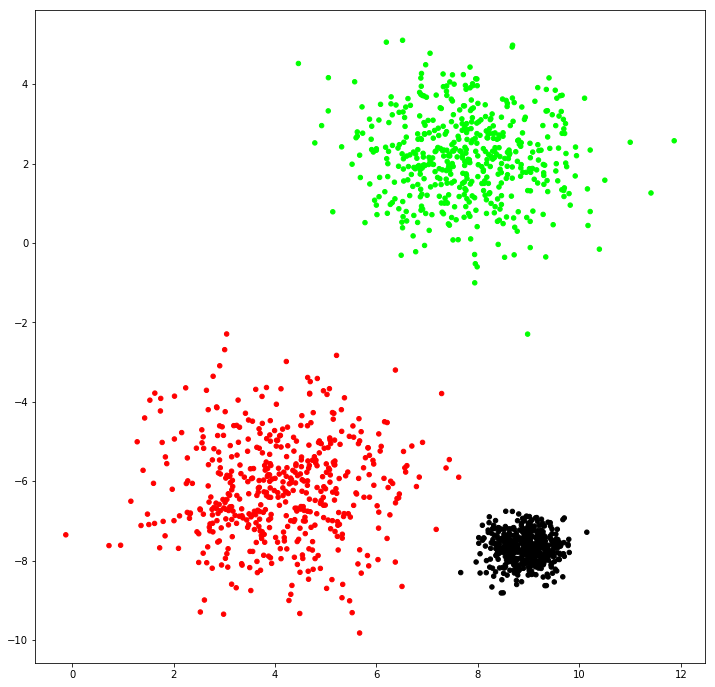

In [197]:
# plot data

X = data[0]
c = data[1]

xs = X[:, 0]
ys = X[:, 1]


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(xs, ys, 20, c=colors(c))

In [186]:

def color(i):
    #colors = ['navy', 'c', 'cornflowerblue', 'gold', 'darkorange', 'navy', 'c', 'cornflowerblue', 'gold', 'darkorange', 'navy', 'c', 'cornflowerblue', 'gold', 'darkorange']
    colors = ["#000000","#FF0000","#00FF00","#0000FF","#FFFF00","#00FFFF","#FF00FF","#C0C0C0","#808080","#800000","#808000","#008000","#800080","#008080","#000080"]
    return colors[i]

def colors(Y):
    return [color(i) for i in Y]

In [187]:
# update_result function
# updates data, gaussian mixtures, and classification

def generate_results(ax, mix):
    Y_ = mix.predict(X)
    means = mix.means_
    covariances = mix.covariances_
    
    # generate scatterplot
    scat = ax.scatter(X[:, 0], X[:, 1], 20, c=[color(i) for i in Y_])
    
    # generate ellipses
    ells = []
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.+angle, color=color(i), animated=True)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ells.append(ell)
        ax.add_patch(ell)
    
    return ells + [scat]
        

In [192]:
# animate results function

# animation settings
interval = 2500
repeat_delay = 2000

def animate(param, param_gm, param_bgm, X, start, end, step):
    
    fig = plt.figure(figsize=(24, 16))
    ax_gm = fig.add_subplot(121)
    ax_bgm = fig.add_subplot(122)
    
    artists = []
    for frame in range(start, end, step):

        # results: scatter and ellipses
        # gm
        gm = mixture.GaussianMixture(**param, **param_gm, max_iter=frame).fit(X)
        results_gm = generate_results(ax_gm, gm)
        # bgm
        bgm = mixture.BayesianGaussianMixture(**param, **param_bgm, max_iter=frame).fit(X)
        results_bgm = generate_results(ax_bgm, bgm)
        
        # frame counter
        frame_counter = ax_gm.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
        if (bgm.converged_ and (bgm.n_iter_ < frame)):
            frame_counter.set_text(str(bgm.n_iter_))
        else:
            frame_counter.set_text(frame)
        
        artists.append(results_gm + results_bgm + [frame_counter])

    
    return ArtistAnimation(fig, artists, interval=interval, repeat_delay=repeat_delay, blit=True)
    

random_state:  433


/Users/anton/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


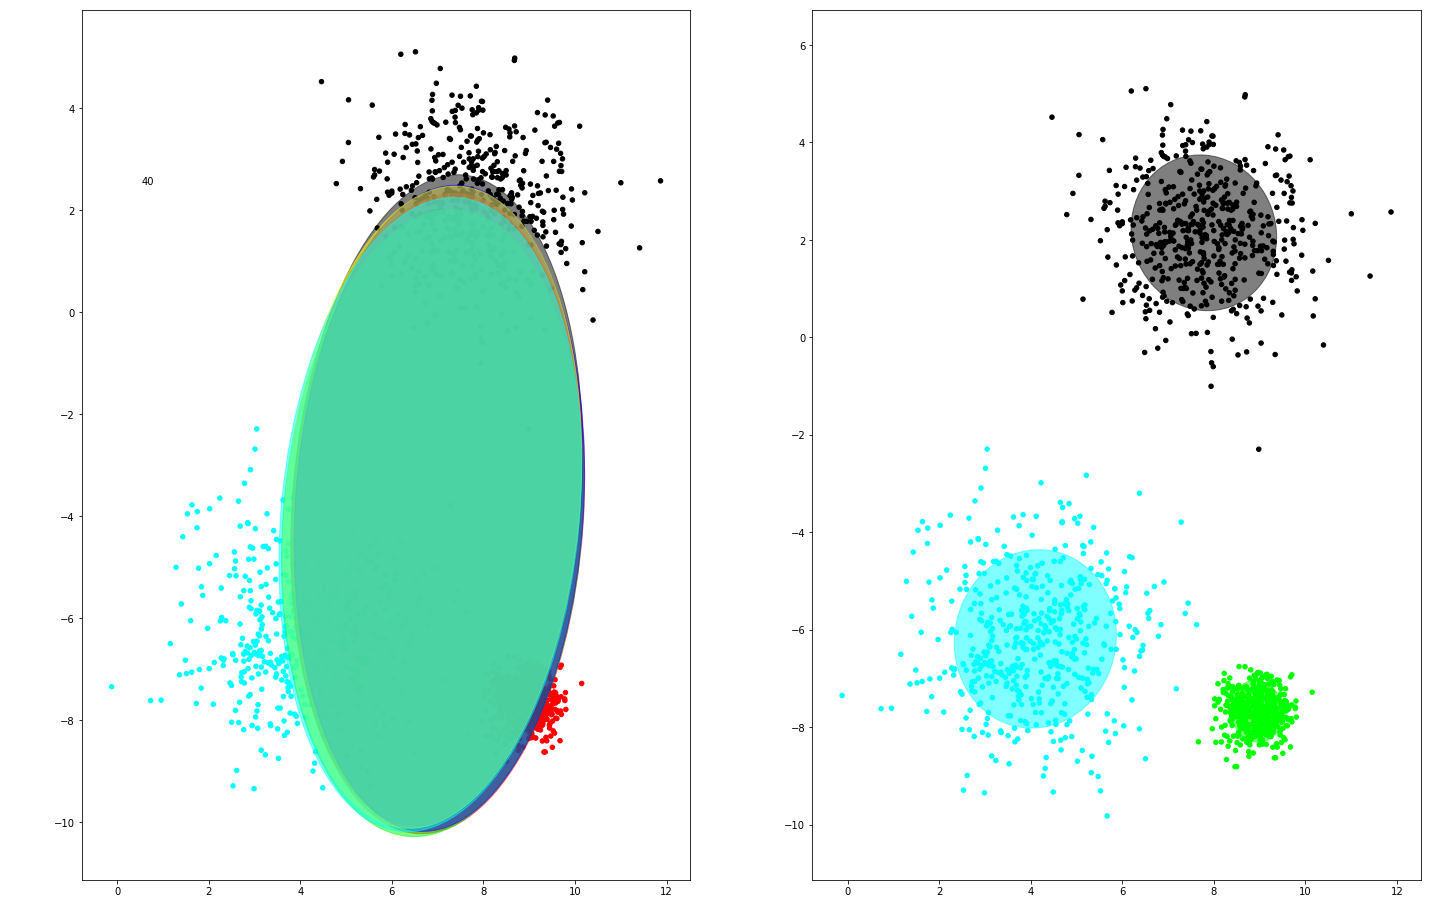

In [198]:
# BayesianGaussianMixture
# settings
param = {
    'n_components': 6,
    'random_state': np.random.randint(0, 999),
    'init_params': 'random'
}

print("random_state: ", param['random_state'])

param_bm = {
    
}

param_bgm = {
    
}


# run
anim = animate(param, param_bm, param_bgm, X, 1, 100, 10)

HTML(anim.to_jshtml())
